In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD 

import re

2024-12-10 16:46:17.282870: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 16:46:17.326295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 16:46:17.326326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 16:46:17.327523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 16:46:17.334488: I tensorflow/core/platform/cpu_feature_guar

# Importing and Visualizing Data
Data is downloaded to home directory. 

Using Kaggle instead

In [2]:
# !pip install kagglehub
# This one takes 3 minutes
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/ridgewayg/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2


In [3]:
import numpy as np
import os
import pandas as pd

# Loading data into the memory is not efficient since it doesn't have enough memory for that much data
# Load filenames into dataframe instead

images = []

labels = []

bounds = []

label_count = 0

images_path = path + r"/images/Images/"
bounds_path = path + r"/annotations/Annotation/"

for label in os.listdir(images_path):
    label_path = images_path + label + "/"
    bound_path = bounds_path + label + "/"

    label_count += 1
    for file in os.listdir(label_path):
        images.append(label_path + file)
        labels.append(label.split('-')[1])
        bounds.append(bound_path + file.split('.')[0])

        

df = pd.DataFrame({"image_path" : images, "label": labels, "bounds": bounds})

df = df[df['label'].isin(df['label'].unique()[:10])]


In [4]:
def bound_extractor(x):
    fild = ''
    with open(x, 'r') as file:
        data = file.read().rstrip()
        
        bound_string = re.findall("(<.*?>)(.*)(<.*?>)",data)
        x_min = int(bound_string[11][1])
        y_min = int(bound_string[12][1])
        x_max = int(bound_string[13][1])
        y_max = int(bound_string[14][1])
        
        coords = [x_min, y_min, x_max, y_max]
        
        #print(coords)
        
        return coords

def cropper(img_path, coords):
    try:
        img = Image.open(img_path)
        cropped = img.crop(coords)
        img.convert('RGB')
        img.save(img_path)
        #return cropped
    except:
        print(img_path)
        return None

df['bounds'] = df['bounds'].apply(lambda x: bound_extractor(x))

df.apply(lambda x: cropper(x["image_path"], x["bounds"]),axis=1)

In [5]:
df.value_counts('label')


label
Maltese_dog            252
Afghan_hound           239
Shih                   214
papillon               196
Blenheim_spaniel       188
Japanese_spaniel       185
Rhodesian_ridgeback    172
toy_terrier            172
Chihuahua              152
Pekinese               149
Name: count, dtype: int64

In [6]:
df.shape

(1919, 3)

In [7]:
X_train, X_temp = train_test_split(df, test_size=0.2, stratify=df["label"], random_state = 42)

label_test_val = X_temp['label']

# 10%.   10%
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (1535, 3)
The shape of test data (192, 3)
The shape of validation data (192, 3)


In [8]:
# parameters
image_size = 255 # Size of the image
image_channel = 3 # Colour scale (RGB)
bat_size = 1 # Number of files/images processed at once

In [9]:
# Applyingimage data gernerator to train and test data
datagen = ImageDataGenerator(
            validation_split=0.2,
            rescale=1./255, # to bring the image range from 0..255 to 0..1
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.01, # randomly zoom image 
            width_shift_range=0.01,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.01,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,
            samplewise_center = True,
            #shear_range = 0.01,
            samplewise_std_normalization = True,
            fill_mode = "nearest")

train_generator = datagen.flow_from_dataframe(X_train,
                                                    x_col= 'image_path',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    class_mode="categorical",
                                                   )
val_generator = datagen.flow_from_dataframe(X_val, 
                                                 x_col= 'image_path',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False,
                                                 class_mode="categorical",
                                                )

test_generator = datagen.flow_from_dataframe(X_test, 
                                                  x_col= 'image_path',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                 )

Found 1535 validated image filenames belonging to 10 classes.
Found 192 validated image filenames belonging to 10 classes.
Found 192 validated image filenames belonging to 10 classes.


In [10]:
# use the data generator
num_classes = len(test_generator.class_indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2717988..3.2498724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2711608..3.2837684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0251245..1.4203808].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5735376..2.0943341].


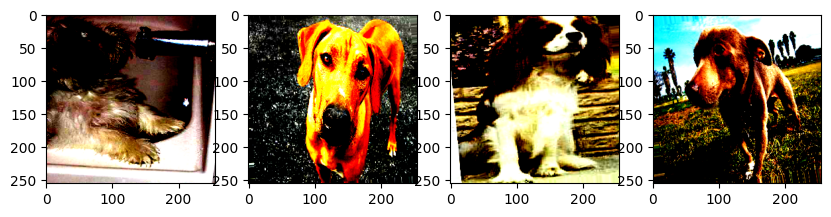

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
#Plots our figures
for i in range(1,5):
  plt.subplot(1, 4, i)
  batch = next(test_generator)
  image_ = batch[0][0]
  plt.imshow(image_)
plt.show()

# CNN
Everything after this is specific to Convolutional Nueral Networks but you can try to look at how it is set up.

In [12]:
from tensorflow.keras.applications import VGG16

# Load the VGG16 model
base_model = VGG16(
    weights = 'imagenet', 
    input_shape = (image_size, image_size, image_channel),
    include_top=False)

#freezing the base model
base_model.trainable = False


2024-12-10 16:46:21.651218: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-10 16:46:21.651250: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dh-node13
2024-12-10 16:46:21.651257: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dh-node13
2024-12-10 16:46:21.651368: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: INVALID_ARGUMENT: expected %d.%d, %d.%d.%d, or %d.%d.%d.%d form for driver version; got "1"
2024-12-10 16:46:21.651386: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 555.42.2


In [13]:
model = Sequential()

# Add maxpooling layers along with convolutional layers
# change activation funcitnos to leaky_relu
# add a dense layer after the flatten

model.add(base_model)

# Input Layer
model.add(Conv2D(32,(3,3),activation='leaky_relu',input_shape = (image_size,image_size,image_channel))) 

model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(filters=64, kernel_size=2, activation='leaky_relu'))
model.add(Dropout(0.2))

# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='leaky_relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

# model.add(Conv2D(filters=256 , kernel_size=2 , padding='same' , activation='leaky_relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(num_classes,activation='softmax')) # Softmax for binary classification

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          147488    
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2, 2, 32)          0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                        

In [14]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
train_generator.target_size

(255, 255)

In [16]:
# Fine-tuning: Unfreeze some layers in ResNet
for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time
fitted = model.fit(train_generator,
                    validation_data = val_generator, 
                    epochs = 20,
                    steps_per_epoch = len(train_generator),
                    validation_steps = len(val_generator),
                   )

Epoch 1/20


2024-12-10 16:46:23.712580: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/sequential/conv2d/LeakyRelu/LeakyReluGrad' exist for missing node 'sequential/conv2d/BiasAdd'.


1535/1535 [==============================] - 133s 86ms/step - loss: 10.6139 - accuracy: 0.1375 - val_loss: 9.9785 - val_accuracy: 0.2396
Epoch 2/20
1535/1535 [==============================] - 132s 86ms/step - loss: 9.6493 - accuracy: 0.2254 - val_loss: 9.1554 - val_accuracy: 0.3750
Epoch 3/20
1535/1535 [==============================] - 131s 86ms/step - loss: 8.8392 - accuracy: 0.3094 - val_loss: 8.4219 - val_accuracy: 0.4635
Epoch 4/20
1535/1535 [==============================] - 131s 86ms/step - loss: 8.1326 - accuracy: 0.3694 - val_loss: 7.7133 - val_accuracy: 0.5312
Epoch 5/20
1535/1535 [==============================] - 132s 86ms/step - loss: 7.4838 - accuracy: 0.4593 - val_loss: 7.1315 - val_accuracy: 0.5885
Epoch 6/20
1535/1535 [==============================] - 133s 86ms/step - loss: 6.9297 - accuracy: 0.5173 - val_loss: 6.5858 - val_accuracy: 0.6562
Epoch 7/20
1535/1535 [==============================] - 132s 86ms/step - loss: 6.4972 - accuracy: 0.5661 - val_loss: 6.2212 - va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1535/1535 [==============================] - 133s 87ms/step - loss: 5.4762 - accuracy: 0.6469 - val_loss: 5.2725 - val_accuracy: 0.6875
Epoch 11/20
 950/1535 [=================>............] - ETA: 45s - loss: 5.2626 - accuracy: 0.6547

In [ ]:
history = model.history

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:

# Fine-tuning: Unfreeze some layers in ResNet
for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    validation_data = val_generator, 
    epochs = 20,
    steps_per_epoch = len(train_generator),
    validation_steps = len(val_generator),
)

In [ ]:
history = model.history

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Using Classical Machine Learning
We will be using KMeans in order to try to classify the dog breeds. It probably won't perform well. 

As a start, we should pick the least well classified breeds and try to get the best scores we can before moving to DNN and CNNs. The image shows the best accuracies achieved in each breed. We will be trying to get the best in the bottom, say 5. 

![image](bar_graph_full.png)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

image_size = 255
bat_size = 32

In [ ]:
def extract_images(generator):
    images = []
    labels = []
    for i, (image_batch, label_batch) in enumerate(generator):
        images.append(image_batch)
        labels.append(label_batch)
        if len(images) >= generator.samples:
            break
    images = np.vstack(images)
    labels = np.vstack(labels)
    return images, labels 

In [ ]:
X_images, y_labels = extract_images(train_generator) 

X_flattened = X_images.reshape(X_images.shape[0], -1)

In [ ]:
kmeans = KMeans(n_clusters=num_classes, random_state=42) 
kmeans.fit(X_flattened)

In [ ]:
cluster_centers_reshaped = kmeans.cluster_centers_.reshape(num_classes, image_size, image_size, 3)
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(cluster_centers_reshaped[i])
    plt.title(f"Cluster {i}")
    plt.axis('off')
plt.show()

In [ ]:
y_pred_train = kmeans.predict(X_flattened)
ari_train = adjusted_rand_score(np.argmax(y_labels, axis=1), y_pred_train)

In [ ]:
conf_matrix_train = confusion_matrix(np.argmax(y_labels, axis=1), y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(4))
plt.title('Confusion Matrix for KMeans Clusters on Training Data')
plt.xlabel('Predicted Clusters')
plt.ylabel('True Labels')
plt.show()

In [ ]:
X_test_images, y_test_labels = extract_images(test_generator)

X_test_flattened = X_test_images.reshape(X_test_images.shape[0], -1)

y_pred_test = kmeans.predict(X_test_flattened)

ari_test = adjusted_rand_score(np.argmax(y_test_labels, axis=1), y_pred_test)

print(f"Adjusted Rand Index (ARI) on the test data: {ari_test:.4f}")

In [ ]:
conf_matrix_test = confusion_matrix(np.argmax(y_test_labels, axis=1), y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(4))
plt.title('Confusion Matrix for KMeans Clusters on Test Data')
plt.xlabel('Predicted Clusters')
plt.ylabel('True Labels')
plt.show()


In [ ]:
y_pred_test = kmeans.predict(X_test_flattened)

conf_matrix = confusion_matrix(np.argmax(y_test_labels, axis=1), y_pred_test)

cluster_to_label_mapping = np.argmax(conf_matrix, axis=1)


y_pred_mapped = np.array([None if cluster >= len(cluster_to_label_mapping) else cluster_to_label_mapping[cluster] for cluster in y_pred_test])

accuracy = np.mean(y_pred_mapped == np.argmax(y_test_labels, axis=1))

print(f"Accuracy of KMeans clustering: {accuracy:.4f}")

## 